## **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import os

## **Import Dataset**

In [2]:
current_directory = os.getcwd() + "/Images"
batch_size_ = 39209
image_width = 28
image_height = 28

In [3]:
data_generator = ImageDataGenerator(rescale=1/255,
                                  validation_split=0.2)

In [4]:
#Split dataset
train_generator = data_generator.flow_from_directory(
    current_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size_,
    subset="training")

Found 31368 images belonging to 43 classes.


In [5]:
validation_generator = data_generator.flow_from_directory(
    current_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size_,
    subset="validation")

Found 7841 images belonging to 43 classes.


In [6]:
#Get x_train, y_train and x_test, y_test
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
# sort y_train and y_test to make every class in its index
# class 0 in column 0 and class 10 in column 10 and so on
def sort_classes(y_array):
    y_array = pd.DataFrame(y_array, columns=[int(i) for i in list(
        train_generator.class_indices.keys())])

    y_array = y_array.reindex(sorted(y_array.columns), axis=1)
    return np.array(y_array)

In [8]:
y_train = sort_classes(y_train)
y_test = sort_classes(y_test)

### **Visualize Samples of the data**

In [9]:
sample = tf.keras.preprocessing.image_dataset_from_directory(
    directory=current_directory, batch_size=32,
    image_size=(image_height, image_width))

classes = sample.class_names

Found 39209 files belonging to 43 classes.


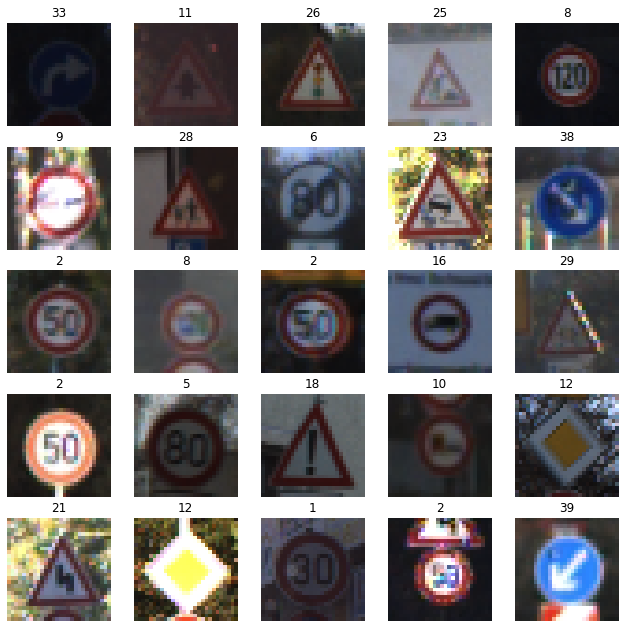

In [10]:
fig, ax = plt.subplots(5, 5, figsize=(11, 11))
row, col = 0, 0
for images, labels in sample.take(1):
    for i in range(25):
        ax[row, col].imshow(images[i].numpy().astype("uint8"))
        ax[row, col].axis("off")
        ax[row, col].set_title(classes[labels[i]])
        col += 1
        if col == 5:
            col = 0
            row += 1
       
        

### **Classes Frequency**

In [11]:
classes = [i for i in range(43)]
counts = np.concatenate((y_train, y_test)).sum(axis=0)

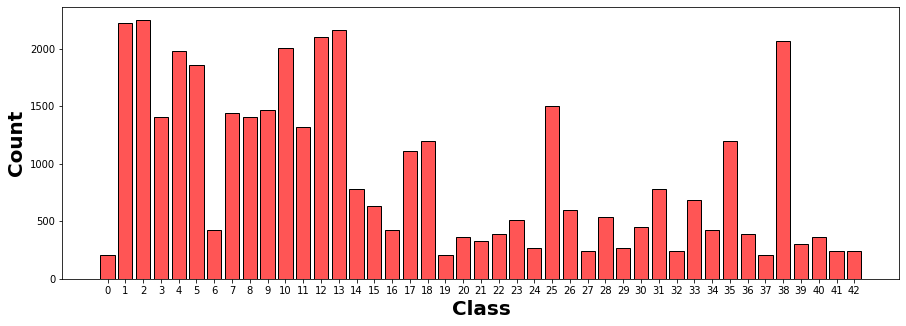

In [12]:
#Visulaize number of images in each class
plt.figure(figsize=(15, 5))
plt.bar(classes, counts, color='#ff5555', edgecolor='black')
plt.xticks([i for i in range(43)])
plt.xlabel("Class", fontsize=20, fontweight="bold")
plt.ylabel("Count", fontsize=20, fontweight="bold")
plt.show()

#### As we can see our classes are imbalanced, this can make our model biased towards majority classes

## **Modeling**

In [13]:
#Create a model
model = Sequential()

#Create an activation function
activation = layers.LeakyReLU()

# add more layers
model.add(layers.Conv2D(32, kernel_size=3, padding="same",
                        input_shape=(image_width, image_height, 3)))
model.add(activation)

model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
model.add(activation)
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, kernel_size=3,padding="same"))
model.add(activation)
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
model.add(activation)

model.add(layers.MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation=activation, kernel_regularizer=regularizers.l2()))
model.add(Dense(43, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         2

In [14]:
#Define some callbacks
#reducing the learning rate by a factor once learning stagnates
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)
early_stop = tf.keras.callbacks.EarlyStopping(restore_best_weights=True,
                                              mode="max", patience=8, 
                                              monitor="val_accuracy")

In [15]:
#compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy",
              metrics=["accuracy"])

In [16]:
#fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50,
         callbacks=[lrr, early_stop])

Epoch 1/50
981/981 [==============================] - 18s 14ms/step - loss: 1.5739 - accuracy: 0.7525 - val_loss: 1.1316 - val_accuracy: 0.8667
Epoch 2/50
981/981 [==============================] - 13s 14ms/step - loss: 0.7298 - accuracy: 0.9472 - val_loss: 0.7389 - val_accuracy: 0.9186
Epoch 3/50
981/981 [==============================] - 13s 14ms/step - loss: 0.6263 - accuracy: 0.9618 - val_loss: 0.5913 - val_accuracy: 0.9356
Epoch 4/50
981/981 [==============================] - 13s 14ms/step - loss: 0.5640 - accuracy: 0.9676 - val_loss: 1.0850 - val_accuracy: 0.8972
Epoch 5/50
981/981 [==============================] - 13s 14ms/step - loss: 0.6002 - accuracy: 0.9697 - val_loss: 0.6331 - val_accuracy: 0.9324
Epoch 6/50
981/981 [==============================] - 13s 14ms/step - loss: 0.5192 - accuracy: 0.9755 - val_loss: 0.8523 - val_accuracy: 0.9221
Epoch 7/50
981/981 [==============================] - 13s 13ms/step - loss: 0.4999 - accuracy: 0.9896 - val_loss: 0.5597 - val_accuracy:

#### The Highest accuracy we could get is 0.9825 on our validation set

## **Saving the model**

In [17]:
model.save("CNN_model.model")

INFO:tensorflow:Assets written to: CNN_model.model\assets


## **Evaluate model perfomance**

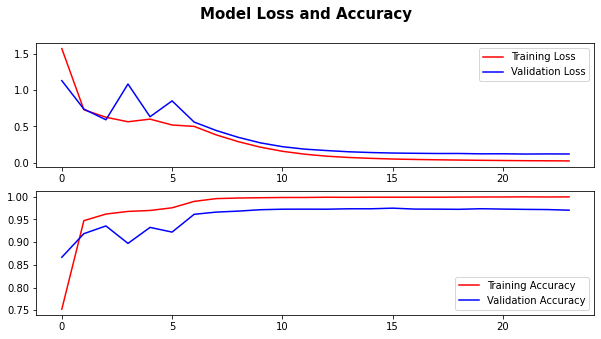

In [18]:
#Plot the training and validation loss and accuracy
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(10)
fig.set_figheight(5)
#Loss
ax[0].plot(model.history.history["loss"], color="r", label="Training Loss")
ax[0].plot(model.history.history["val_loss"], color="b", label="Validation Loss")
ax[0].legend()
#Accuracy
ax[1].plot(model.history.history["accuracy"], color="r", label="Training Accuracy")
ax[1].plot(model.history.history["val_accuracy"], color="b", label="Validation Accuracy")
ax[1].legend()
fig.suptitle("Model Loss and Accuracy", fontsize=15, fontweight='bold');


In [19]:
#Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Plots confusion matrix for every class"""
    f, ax = plt.subplots(6, 8, figsize=(30, 20))
    fig.set_figheight(11)
    fig.set_figwidth(11)
    row, col = 0, 0
    label_font = {'size':'15',
                  'weight' : 'bold'}
    for i in range(48):
        if i < 43:
            disp = ConfusionMatrixDisplay(confusion_matrix(y_test[:, i],
                                                           y_pred[:, i]),
                                          display_labels=[0, i])
            disp.plot(ax=ax[5-row, col])
            disp.ax_.set_title(f"class {i}")
            
            if row != 0:
                disp.ax_.set_xlabel('')
            else:
                disp.ax_.set_xlabel('Predicted labels', fontdict=label_font);
            if col > 0:
                disp.ax_.set_ylabel('')
            else:
                disp.ax_.set_ylabel('Observed labels', fontdict=label_font);
            disp.im_.colorbar.remove()
        
        else:
            ax[5-row, col].set_axis_off() #Remove extra plots
        
        col += 1
        if col == 8:
            col = 0
            row += 1
        
    plt.subplots_adjust(wspace=0.10, hspace=0.2)
    f.colorbar(disp.im_, ax=ax)
    plt.show()
    

In [20]:
def predict(model, X_test):
    """returns sparse matrix with predictions"""
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    y_pred = np.array(pd.get_dummies(y_pred))
    return y_pred

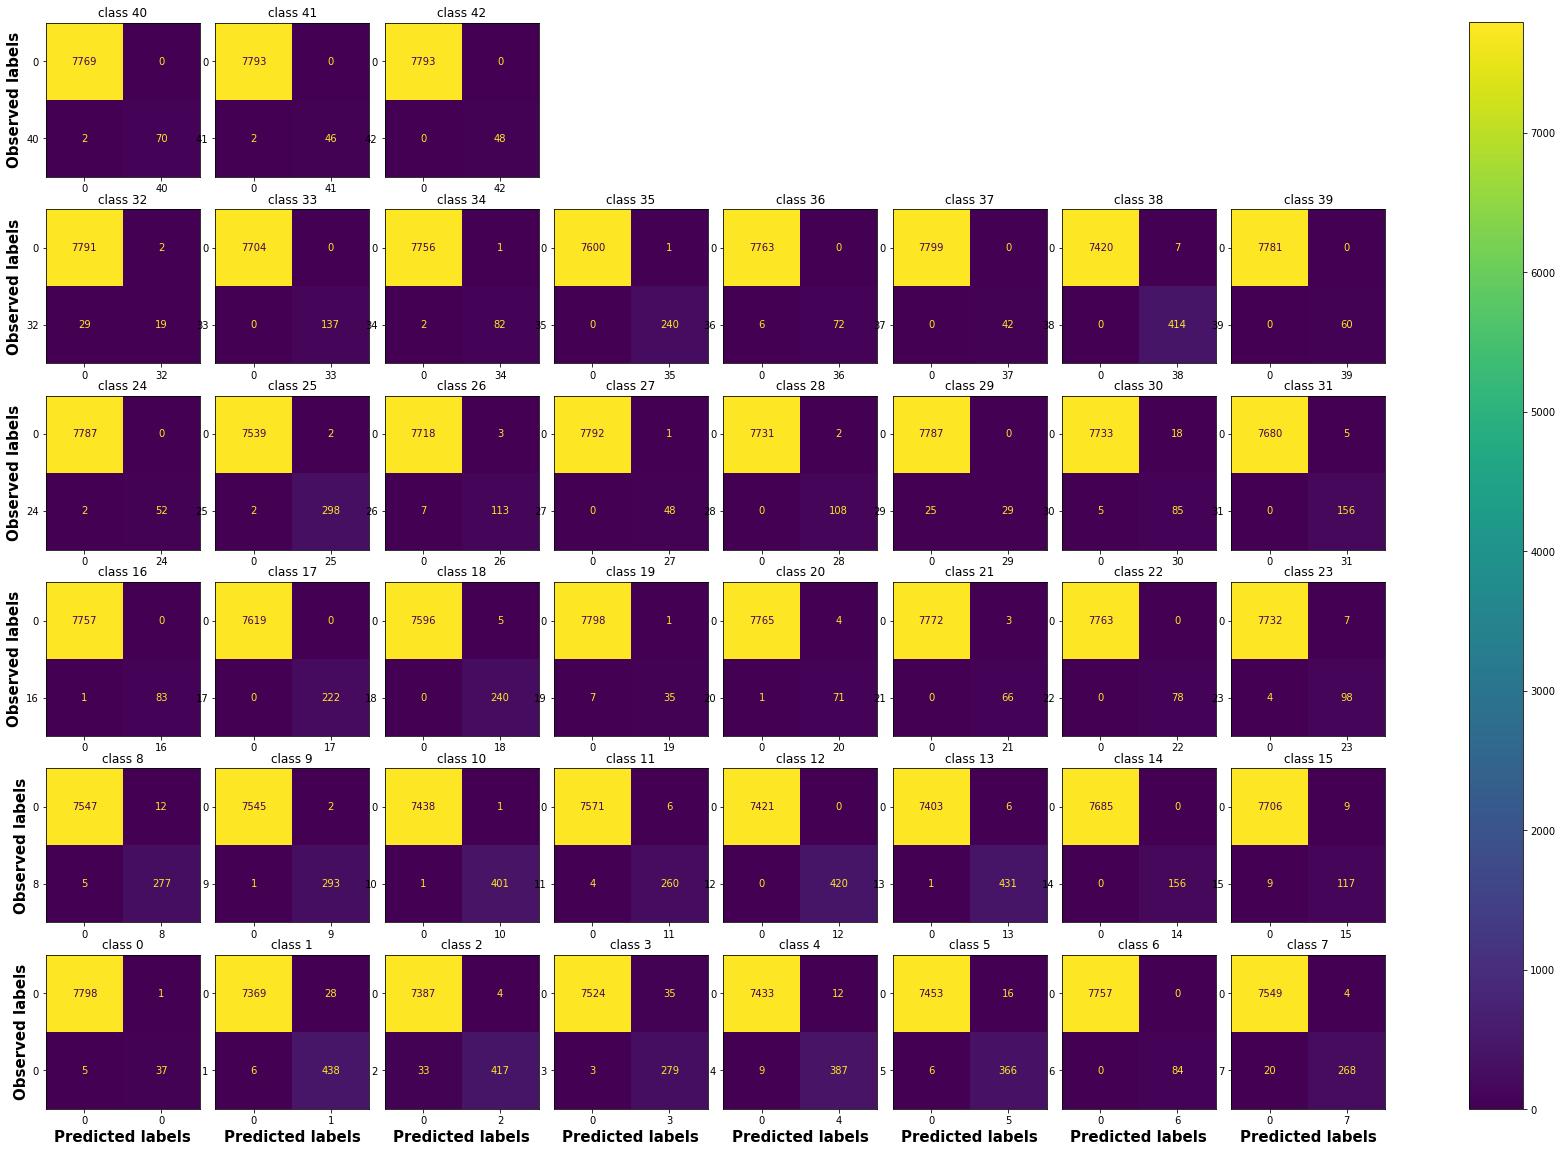

In [21]:
y_pred = predict(model, X_test)
plot_confusion_matrix(y_test, y_pred)

In [22]:
#Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        42
           1       0.94      0.99      0.96       444
           2       0.99      0.93      0.96       450
           3       0.89      0.99      0.94       282
           4       0.97      0.98      0.97       396
           5       0.96      0.98      0.97       372
           6       1.00      1.00      1.00        84
           7       0.99      0.93      0.96       288
           8       0.96      0.98      0.97       282
           9       0.99      1.00      0.99       294
          10       1.00      1.00      1.00       402
          11       0.98      0.98      0.98       264
          12       1.00      1.00      1.00       420
          13       0.99      1.00      0.99       432
          14       1.00      1.00      1.00       156
          15       0.93      0.93      0.93       126
          16       1.00      0.99      0.99        84
          17       1.00    

#### Looking at our confusion matrix we will notice that classes that has low number of images can have a higher accuracy like class 19 and classes with higher number of images may have low accuracy, and this is due to the more images you have the higher your chance to get wrong predictions.

## **Model Deployment**

In [23]:
#Save y_train and X_train to use them in deployment
np.save("y_train", y_train)
np.save("X_train", X_train)

#### Model Deployment will be in another Notebook called **Model Deployment** so you don't have to retrain the model